# U-Net

U-Net is a Deep Learning architecture used for semantic segmentation tasks in image analysis.

First intorduced in a paper titled in a paper titled "U-Net: Convolutional Networks for Biomedical Image Segmentation".

## Architecture

![Unet Diagram](./../../resources/images/unet1.png)

<b>Encoder(Contraction Path)</b>

The encoder is a series of convolutional and pooling layers that progressively downsample the input image to extract features at multiple scales.

In the Encoder, the size of the image is gradually reduced while the depth gradually increases. The subsequent feature maps of the convolutons learn the general features of the image.

<b>Decoder(Expansion Path)</b>

The decoder consists of a series of convolutional and upsampling layers that upsample the feature maps to the original input image size while also incorporating the high-resolution features from the encoder. This allows the decoder to produce segmentation masks that have the same size as the original input image.


In the Decoder, the size of the image gradually increases while the depth gradually decreases. By upsampling, the general fatures of the image learned by the convolutional layers are "redistributed" back in an image of the same size.

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.utils.data import Subset
import torch.nn.functional as F

In [2]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, 
        # with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(self.n_channels, 64, kernel_size=3, padding='same') # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding='same') # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding='same') # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding='same') # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding='same') # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding='same') # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding='same') # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding='same') # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding='same') # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding='same') # output: 28x28x1024

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # output: 56x56x512
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding='same') # output: 54x54x512
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding='same') # output: 52x52x512

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # output: 104x104x256
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding='same') # output: 102x102x256
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding='same') # output: 100x100x256

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # output: 200x200x128
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding='same') # output: 198x198x128
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding='same') # output: 196x196x128

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # output: 392x392x64
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding='same') # output: 390x390x64
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding='same') # output: 388x388x64

        # Output layer
        self.outconv = nn.Conv2d(64, n_classes, kernel_size=1) # output: 388x388xn_classes

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        #print(xe11.shape)
        xe12 = relu(self.e12(xe11))
        #print(xe12.shape)
        xp1 = self.pool1(xe12)
        #print(xp1.shape)

        xe21 = relu(self.e21(xp1))
        #print(xe21.shape)
        xe22 = relu(self.e22(xe21))
        #print(xe22.shape)
        xp2 = self.pool2(xe22)
        #print(xp2.shape)

        xe31 = relu(self.e31(xp2))
        #print(xe31.shape)
        xe32 = relu(self.e32(xe31))
        #print(xe32.shape)
        xp3 = self.pool3(xe32)
        #print(xp3.shape)

        xe41 = relu(self.e41(xp3))
        #print(xe41.shape)
        xe42 = relu(self.e42(xe41))
        #print(xe42.shape)
        xp4 = self.pool4(xe42)
        #print(xp4.shape)

        xe51 = relu(self.e51(xp4))
        #print(xe51.shape)
        xe52 = relu(self.e52(xe51))
        #print(xe52.shape)

        # Decoder
        xu1 = self.upconv1(xe52)
        #print(xu1.shape)
        #xu11 = torch.cat([xu1, xe42], dim=1)
        xu11 = self.concat(xu1, xe42)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        #xu22 = torch.cat([xu2, xe32], dim=1)
        xu22 = self.concat(xu2, xe32)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        #xu33 = torch.cat([xu3, xe22], dim=1)
        xu33 = self.concat(xu3, xe22)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        #xu44 = torch.cat([xu4, xe12], dim=1)
        xu44 = self.concat(xu4, xe12)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out
    
    def concat(self, x1, x2):
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x

    


## Training

In [3]:
from data_loading import BasicDataset, CarvanaDataset
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import wandb
import logging
from pathlib import Path
from dice_score import dice_loss
from evaluate import evaluate
import torch.nn.functional as F
import os
import numpy as np
from PIL import Image

In [4]:
dir_img = Path('/home/mp/viscode-github/datasets/carvanachallenge/carvana-image-masking-challenge/train')
dir_mask = Path('/home/mp/viscode-github/datasets/carvanachallenge/carvana-image-masking-challenge/train_masks')
dir_checkpoint = Path('./checkpoints/')

In [14]:
def train(
        model,
        dataset: BasicDataset,
        device,
        epochs: int = 5,
        batch_size: int = 16,
        learning_rate: float = 1e-7,
        val_percent: float = 0.1,
        save_checkpoint: bool = False,
        img_scale: float = 0.5,
        amp: bool = True,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):
    true_masks_arr = []
    masks_pred_arr = []
    dataset = dataset
    print('split')
    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))
    
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    print(f'len train_set: {len(train_set)}')
    print(f'len val_set: {len(val_set)}')

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count())
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # (Initialize logging)
    experiment = wandb.init(project='U-Net3', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    global_step = 0

    print('begin training')
    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last, non_blocking=True)
                true_masks = true_masks.to(device=device, dtype=torch.long, non_blocking=True)

                with torch.autocast(device.type if device.type == 'cuda' else 'cpu', enabled=amp):
                    masks_pred = model(images)

                    loss = criterion(masks_pred.squeeze(1), true_masks.float())
                    loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                        

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))

                        experiment.log({
                            'learning rate': optimizer.param_groups[0]['lr'],
                            'validation Dice': val_score,
                            'images': wandb.Image(images[0].cpu()),
                            'masks': {
                                'true': wandb.Image(true_masks[0].float().cpu()),
                                'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                            },
                            'step': global_step,
                            'epoch': epoch,
                            **histograms
                        })
                        print('EVALUATION')
                        true_masks_arr.append(true_masks[0].float().cpu())
                        masks_pred_arr.append(masks_pred[0].float().cpu())
                        #Image.fromarray((true_masks[0].float().cpu().numpy() * 255).astype(np.uint8)).show()
                        #Image.fromarray((masks_pred.argmax(dim=1)[0].float().cpu().numpy() * 255).astype(np.uint8)).show()


        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            state_dict['mask_values'] = dataset.mask_values
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')
    return true_masks_arr, masks_pred_arr


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=1)
model = model.to(memory_format=torch.channels_last)
model.to(device=device)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1

In [7]:
img_scale = 0.25
dataset = CarvanaDataset(dir_img, dir_mask, img_scale)

100%|██████████| 5088/5088 [00:05<00:00, 909.53it/s]


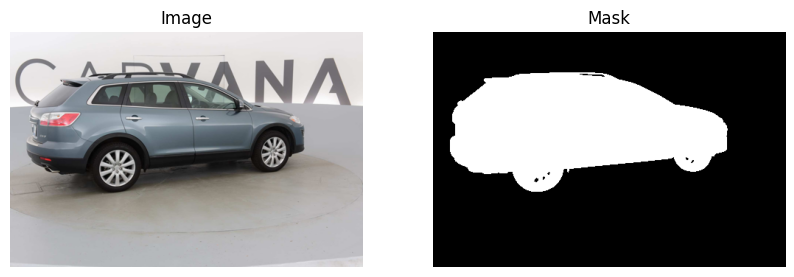

In [16]:
import matplotlib.pyplot as plt

# Get a sample from the dataset
sample = dataset[2]
image = sample['image']
mask = sample['mask']

# Convert the image and mask to numpy arrays for visualization
image_np = image.permute(1, 2, 0).numpy()
mask_np = mask.numpy()

# Plot the image and its mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_np)
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(mask_np, cmap='gray')
ax[1].set_title('Mask')
ax[1].axis('off')

plt.show()

In [17]:
# # Pass 100 images and print the loss of each
# for i in range(100):
#     sample = dataset[i]
#     image = sample['image'].unsqueeze(0).to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
#     mask = sample['mask'].unsqueeze(0).to(device=device, dtype=torch.long)

#     with torch.no_grad():
#         output = model(image)

#     criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
#     if model.n_classes == 1:
#         loss = criterion(output.squeeze(1), mask.float())
#         loss += dice_loss(F.sigmoid(output.squeeze(1)), mask.float(), multiclass=False)


#     print(f'Image {i} Loss: {loss.item()}')


In [18]:
# todo
# fp16
# gradscaler
# wandb


In [19]:
checkpoint_path = './checkpoints/checkpoint_epoch60.pth'
state_dict = torch.load(checkpoint_path, map_location=device)
if 'mask_values' in state_dict:
	del state_dict['mask_values']
model.load_state_dict(state_dict)
model.to(device=device)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1

In [20]:
tr, pr = train(model, dataset, device, epochs=2, batch_size=32)

split
len train_set: 4580
len val_set: 508
begin training


Epoch 1/2:  20%|█▉        | 896/4580 [00:10<00:32, 112.21img/s, loss (batch)=0.121]

tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
EVALUATION


Epoch 1/2:  39%|███▉      | 1792/4580 [00:22<00:24, 111.94img/s, loss (batch)=0.114] 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
EVALUATION


Epoch 1/2:  59%|█████▊    | 2688/4580 [00:35<00:16, 114.38img/s, loss (batch)=0.214]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
EVALUATION


Epoch 1/2:  78%|███████▊  | 3584/4580 [00:47<00:08, 111.25img/s, loss (batch)=0.121]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
EVALUATION


Epoch 1/2:  98%|█████████▊| 4480/4580 [00:59<00:00, 115.59img/s, loss (batch)=0.153]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
EVALUATION


Epoch 2/2:  17%|█▋        | 768/4580 [00:09<00:33, 114.73img/s, loss (batch)=0.147]

tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
EVALUATION


Epoch 2/2:  36%|███▋      | 1664/4580 [00:21<00:26, 110.82img/s, loss (batch)=0.131]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
EVALUATION


Epoch 2/2:  56%|█████▌    | 2560/4580 [00:33<00:17, 114.80img/s, loss (batch)=0.175]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
EVALUATION


Epoch 2/2:  75%|███████▌  | 3456/4580 [00:46<00:10, 110.58img/s, loss (batch)=0.128]

tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
EVALUATION


Epoch 2/2:  95%|█████████▌| 4352/4580 [00:58<00:02, 113.00img/s, loss (batch)=0.13] 

tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
EVALUATION


Epoch 2/2: 100%|██████████| 4580/4580 [01:04<00:00, 71.13img/s, loss (batch)=0.152]


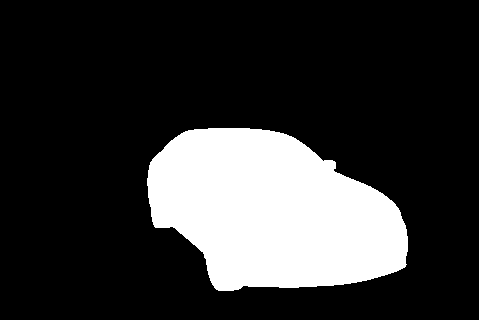

In [21]:
Image.fromarray(tr[1].cpu().numpy().astype(np.uint8) *255)

In [22]:
is_all_zero = torch.all(pr[5] == 0)
print(is_all_zero)

tensor(False)


In [27]:
tr[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [30]:
pr[0].argmax(dim=1)

tensor([[287, 288, 279, 279, 279, 280, 270, 270, 270, 286, 287, 286, 287, 286,
         287, 287, 287, 287, 287, 287, 287, 286, 287, 287, 287, 287, 287, 287,
         286, 286, 285, 285, 285, 285, 283, 283, 283, 283, 106, 106, 106, 107,
         107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108,
         108, 107, 107, 107, 106, 106, 105, 105, 104, 104, 103, 103, 103, 103,
         103, 283, 283, 283, 283, 283, 283, 282, 281, 280, 280, 280, 280, 280,
         281, 281, 281, 281, 108, 108, 108, 107, 107, 106, 105, 103, 101, 100,
          97,  95, 281, 281, 281, 111, 111, 111, 110, 111, 110, 110, 110, 111,
         110, 110, 110, 111, 110, 110, 110, 111, 119, 120, 121, 122, 121, 122,
         123, 122, 123, 124, 128, 130, 128, 132, 132, 131, 132, 131, 131, 131,
         126, 126, 128, 128, 128, 128, 129, 128, 129, 128, 129, 155, 156, 159,
         119, 159, 116, 116, 115, 115, 116, 116, 116, 116, 117, 116, 119, 119,
         119, 120, 119, 118, 117, 116, 117, 118, 117

In [26]:
(F.sigmoid(pr[0]) > 0.5) * 255

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [23]:
pr[5]

tensor([[[ -1.8086,  -2.9395,  -3.4980,  ...,  -6.6797,  -5.6406,  -3.5664],
         [ -2.8340,  -4.5664,  -5.4570,  ..., -10.9453,  -9.0938,  -5.7852],
         [ -3.4258,  -5.4844,  -6.5664,  ..., -13.8203, -11.4531,  -7.1875],
         ...,
         [ -4.3047,  -6.7070,  -8.2734,  ...,  -5.4688,  -4.3516,  -2.6328],
         [ -3.5039,  -5.4648,  -6.8320,  ...,  -4.1602,  -3.2207,  -2.0332],
         [ -2.1855,  -3.3965,  -4.2500,  ...,  -2.4883,  -1.9141,  -1.1621]]],
       grad_fn=<ToCopyBackward0>)

## Predict

In [11]:
from PIL import Image
from predict import predict_img, plot_img_and_mask

In [12]:
dir_test = Path('/home/mp/viscode-github/datasets/carvanachallenge/carvana-image-masking-challenge/test')

In [13]:
dir_images = [x for x in dir_test.iterdir() if x.is_file()]

In [14]:
img = Image.open(dir_images[0])

In [15]:
mask = predict_img(net=model,
                           full_img=img,
                           scale_factor=img_scale,
                           out_threshold=0.5,
                           device=device)

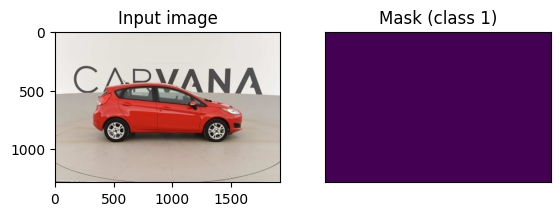

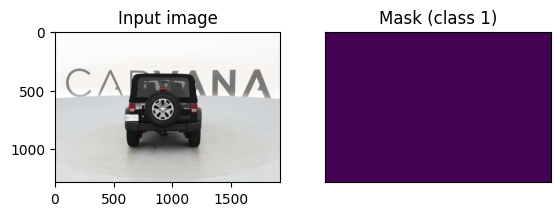

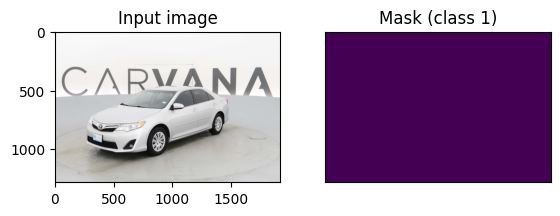

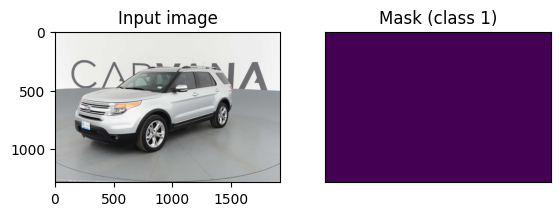

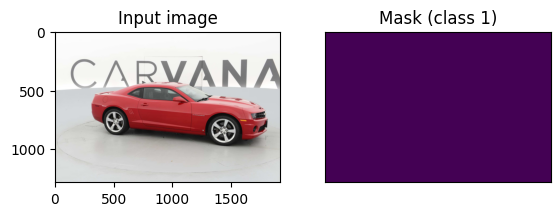

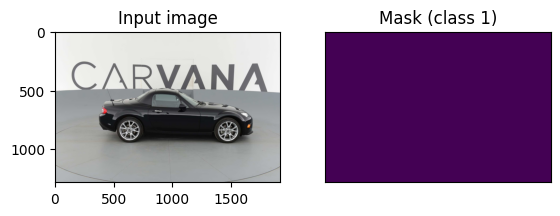

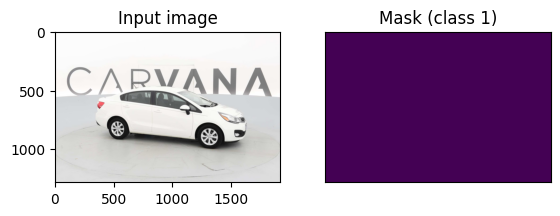

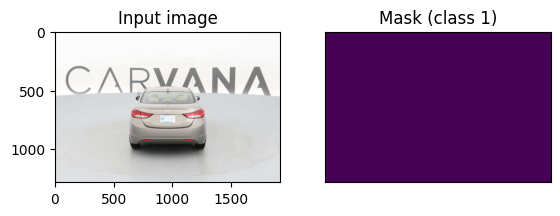

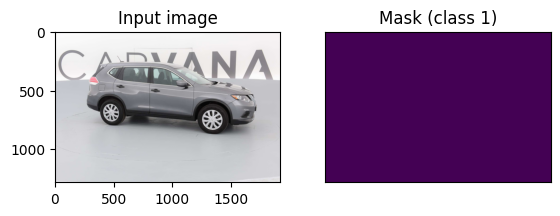

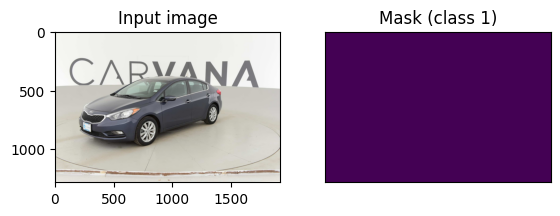

In [17]:
for i, filename in enumerate(dir_images[:10]):
    logging.info(f'Predicting image {filename} ...')
    img = Image.open(filename)

    mask = predict_img(net=model,
                            full_img=img,
                            scale_factor=img_scale,
                            out_threshold=0.5,
                            device=device)

    plot_img_and_mask(img, mask)

In [19]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

0

In [36]:
import numpy as np

In [68]:
aa = Image.open('./../../media_images_pred_13405_d164934d1afd8a2c8740.png')
bb = Image.open('./../../media_images_true_13405_ae5c2fb4fc11e51679e5.png')

In [71]:
a = np.asarray(aa)

In [75]:
a[1][1]

array([  0,   0,   0, 255], dtype=uint8)

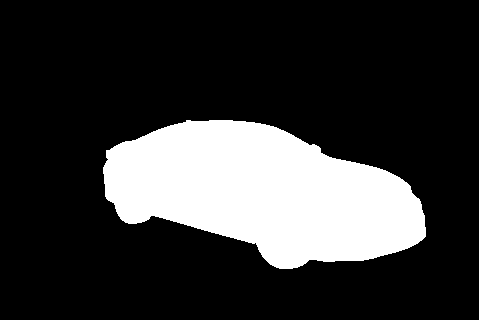

In [48]:
Image.fromarray(np.asarray(bb))

In [50]:
from collections import Counter
c1 = Counter(np.asarray(aa).flatten())
c2 = Counter(np.asarray(bb).flatten())

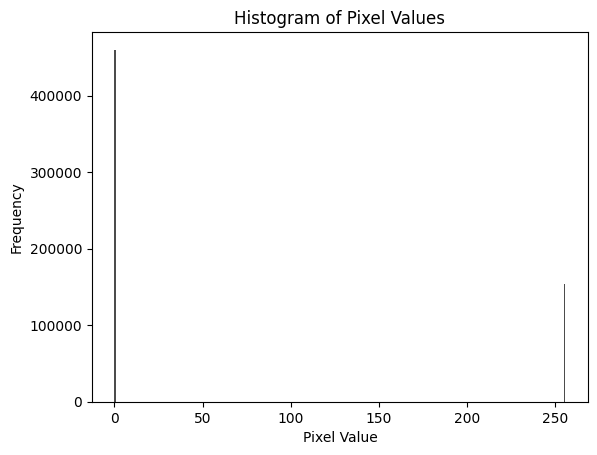

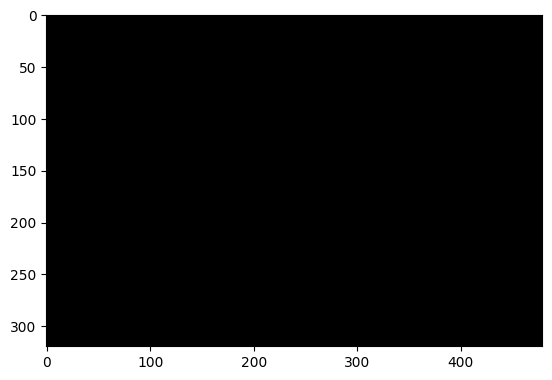

In [65]:
import numpy as np

import matplotlib.pyplot as plt
# Convert the PIL image to a numpy array
aa_np = np.array(aa)
# Plot histogram of pixel values
plt.hist(aa_np.flatten(), bins=256, range=(0, 256), color='black', alpha=0.7)
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()



# Plot the image
plt.imshow(aa_np, cmap='gray')
plt.show()

In [56]:
print(c1, c2)

Counter({np.uint8(0): 459840, np.uint8(255): 153280}) Counter({np.uint8(0): 363804, np.uint8(255): 249316})


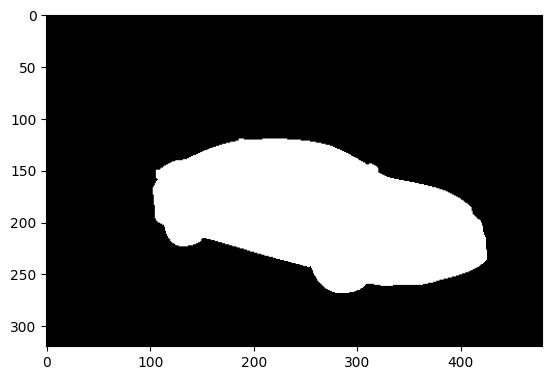

In [67]:
import matplotlib.pyplot as plt

plt.imshow(bb, cmap='gray', vmin=0, vmax=255)
plt.show()

In [64]:
train_model(
            model=model,
            device=device,
        )

Epoch 1/1:   0%|          | 0/4580 [00:00<?, ?img/s]/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:682: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


device train: cpu


Epoch 1/1:   0%|          | 0/4580 [00:07<?, ?img/s]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 119 for tensor number 1 in the list.